# Discrete spatial models

## Install required libraries

In [1]:
#!pip install -r requirements.txt

In [2]:
from src_import.modules import *
from src_import.func import *
plt.style.use('seaborn-poster')

/Users/giulia/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


# Conditionally autoregressive models

The boston housing dataset, records housing values in Boston census tracts (Harrison and Rubinfeld, 1978) corrected for a few errors (Gilley and Pace, 1996).

The CRS is given by the longitude and latitude of the observations (Bivand, 2017).

|Variable |	Description|
| --- | --- |
|town |	Town name
|medv | Median value of owner-occupied homes (in USD 1,000)
|cmedv | Corrected median value of owner-occupied housing (in USD 1,000)
|crim | Crime per capita
|zn	| Proportions of residential land zoned for lots over 25,000 sq. ft per town
|indus |	Proportions of non-retail business acres per town
|chas |	Whether the tract borders Charles river (1 = yes, 0 = no)
|nox |	Nitric oxides concentration (in parts per 10 million)
|rm |	Average number of rooms per dwelling
|age |	Proportions of owner-occupied units built prior to 1940
|dis |	Weigthed distances to five Boston employment centres
|rad |	Index of accesibility to radial highways per town
|tax |	Full-value property-tax rate per USD 10,000 per town
|ptratio |	Pupil-teacher ratios per town
|b	 | $1000 ∗(B − 0.63)^2$ where $B$ is the proportion of  people of African American descent by town
|lstat | Percentage of lower status of the population

### Let's read in the data

In [3]:
boston_housing = BOSTONHOUSING()

### Let's plot the data

In [4]:
variable = 'cmedv'
description='Corrected median value of owner-occupied housing (in USD 1,000)'
ramp = str(list(np.linspace(start=0, stop=50, num=21)))
ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'

Map(
    Layer(boston_housing.data,
        f'color: {ramp_str}',
        {'click': [{
            'title': '',
            'value': f'${variable}'
        }]},
        legend={
            'type': 'color-continuous-polygon',
            'prop': 'color',
            'title':  f'{description}'
        }),
        show_info=True
)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
## Load libraries
source('./src_import/modules.R')
source('./src_import/func.R')

R[write to console]: Loading required package: devtools

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spdep

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3

R[write to console]: Loading required package: rgdal

R[write to console]: rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 sh

### Let's read in the data

In [7]:
%%R
boston_housing.shp <- readOGR(dsn = "./data/boston_housing.shp")
boston_housing.shp$GEOID <- 1:length(boston_housing.shp)

OGR data source with driver: ESRI Shapefile 
Source: "/Users/giulia/Documents/GitHub/research/projects/ebook/data/boston_housing.shp", layer: "boston_housing"
with 506 features
It has 36 fields


### Let's exclude from training censored observations

This dataset constains censored observations in the response variable, which corresponds to Census tracts with a higher median housing value then $50,000. For this reason, we will not use the censored values for training the model (for INLA these will be set to missing and for the GAM model we will set the weights of these areas to zero). Although these areas will not be used for training, predictions will be computed so that inference on the housing value in these areas is still possible.

In [8]:
%%R

boston_housing.shp$CMEDV2 <- boston_housing.shp$CMEDV
boston_housing.shp$CMEDV2[boston_housing.shp$CMEDV2 == 50.0] <- NA
boston_housing.shp$w <- ifelse(is.na(boston_housing.shp$CMEDV2),0,1)

### Let's compute first order neighbours

We can compute adjacency matrix using the function poly2nb can be used, which by default assume that two areas are neighbours if they share at least a segment (queen adjacency).

In [9]:
%%R
#Compute first order neighbours
boston_housing.data <- droplevels(as(boston_housing.shp, 'data.frame'))
boston_housing.nb <- poly2nb(boston_housing.shp, row.names = boston_housing.shp$GEOID)
names(boston_housing.nb) <- attr(boston_housing.nb, "region.id")

#Convert it to a binary adjacency matrix
boston_housing.adj <- nb2mat(boston_housing.nb , style = "B")

#Convert it to a binary adjacency list
boston_housing.list <- nb2listw(boston_housing.nb, style="B")

### Let's fit a non-spatial model for the corrected median value of owner-occupied housing (in USD 1,000)

Here we will use the base model developed in Harrison and Rubinfeld (1978) but other termd will be added to account for the spatially structured random effects. The Harrison and Rubinfeld model includes 13 linear covariates as fixed effects (see formula below).

To fit the model, we will use a Generalized Linear Model (GLM) and assume a Gamma family for the response, to account for the skeweness in the distribution.

Text(0.5, 1.0, 'Corrected median value of owner-occupied housing (in USD 1,000)')

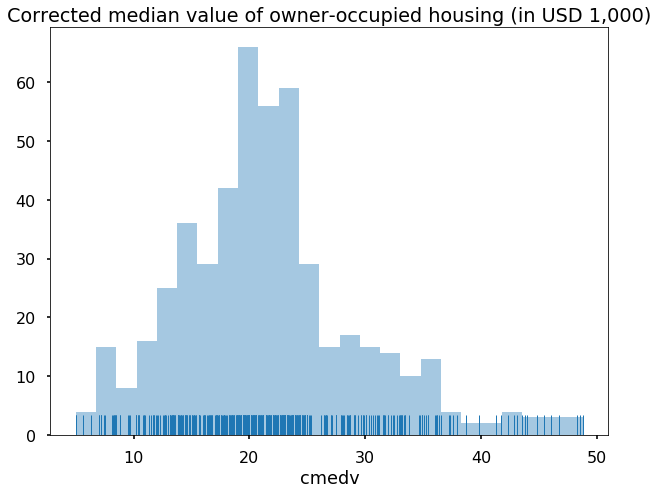

In [10]:
plt.figure(figsize=(10,7.5))
sns.distplot(boston_housing.data.cmedv[boston_housing.data.cmedv<50], bins = 25,kde=False, rug=True)
plt.title('Corrected median value of owner-occupied housing (in USD 1,000)')

In [11]:
%%R
ff_base <- as.formula('CMEDV ~ CRIM + ZN + INDUS + CHAS + I(NOX^2) + I(RM^2) +
                        + AGE + log(DIS) + log(RAD) + TAX + PTRATIO + B + log(LSTAT)')
boston_housing.base <- gam(ff_base,
          data = boston_housing.data,
          weight = w,
          family = Gamma(link=log),
          control = gam.control(nthreads = 4))
boston_housing.shp@data$base <- as.numeric(predict(boston_housing.base,type = 'response'))
summary(boston_housing.base)


Family: Gamma 
Link function: log 

Formula:
CMEDV ~ CRIM + ZN + INDUS + CHAS + I(NOX^2) + I(RM^2) + +AGE + 
    log(DIS) + log(RAD) + TAX + PTRATIO + B + log(LSTAT)

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.413e+00  1.474e-01  29.939  < 2e-16 ***
CRIM        -1.068e-02  1.144e-03  -9.338  < 2e-16 ***
ZN          -3.189e-05  4.765e-04  -0.067 0.946670    
INDUS        6.578e-04  2.226e-03   0.295 0.767763    
CHAS1        5.690e-02  3.308e-02   1.720 0.086039 .  
I(NOX^2)    -5.755e-01  1.049e-01  -5.485 6.62e-08 ***
I(RM^2)      7.228e-03  1.333e-03   5.422 9.25e-08 ***
AGE         -2.922e-04  4.963e-04  -0.589 0.556246    
log(DIS)    -1.642e-01  3.148e-02  -5.216 2.70e-07 ***
log(RAD)     8.322e-02  1.771e-02   4.700 3.38e-06 ***
TAX         -4.315e-04  1.136e-04  -3.797 0.000165 ***
PTRATIO     -3.067e-02  4.669e-03  -6.569 1.29e-10 ***
B            3.419e-04  9.449e-05   3.618 0.000327 ***
log(LSTAT)  -3.245e-01  2.610e-02 -12

### Let's now add a spatial smooth using a Markov Random Field (MRF) smooth

To account for the residual spatial dependence, we can add to the base formula above a spatial smooth using the "mrf" (Markov Random Field) smooth available in the R package <b>mgcv</b>.

To have neighbouring regions with similar parameters $\gamma$, the smooth works by imposing the penalty
 
$J(\gamma) = \sum_i \sum_{j \in N(i)} (\gamma_i - \gamma_j)^2 = \boldsymbol \gamma^T \boldsymbol S \boldsymbol \gamma$

where $N(i)$ represents the neighborhood of region $i$ and the $S_{ij} = -1$ if $j \in N(i)$ and  $S_{jj} = \# N(i)$.

In [12]:
%%R
## MRF smooth using mgcv
ff_GAMmrf <- update(ff_base, . ~. + s(GEOID, bs = "mrf", xt = list(nb = boston_housing.nb), k = 20))
boston_housing.GAMmrf <- gam(ff_GAMmrf,
          data = boston_housing.data,
          weight = w,
          family = Gamma(link=log),
          control = gam.control(nthreads = 4))
boston_housing.shp@data$GAMmrf <- as.numeric(predict(boston_housing.GAMmrf,type = 'response'))
summary(boston_housing.GAMmrf)


Family: Gamma 
Link function: log 

Formula:
CMEDV ~ CRIM + ZN + INDUS + CHAS + I(NOX^2) + I(RM^2) + AGE + 
    log(DIS) + log(RAD) + TAX + PTRATIO + B + log(LSTAT) + s(GEOID, 
    bs = "mrf", xt = list(nb = boston_housing.nb), k = 20)

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.292e+00  1.532e-01  21.485  < 2e-16 ***
CRIM        -7.793e-03  9.306e-04  -8.374 6.33e-16 ***
ZN           1.824e-04  4.173e-04   0.437 0.662244    
INDUS        3.162e-04  1.842e-03   0.172 0.863809    
CHAS1       -6.953e-02  2.857e-02  -2.434 0.015311 *  
I(NOX^2)    -6.887e-02  1.097e-01  -0.628 0.530500    
I(RM^2)      1.088e-02  1.125e-03   9.675  < 2e-16 ***
AGE         -1.305e-03  4.292e-04  -3.041 0.002486 ** 
log(DIS)     8.227e-02  7.596e-02   1.083 0.279358    
log(RAD)     3.415e-02  1.656e-02   2.063 0.039668 *  
TAX         -4.058e-04  9.653e-05  -4.204 3.13e-05 ***
PTRATIO     -1.581e-02  4.184e-03  -3.777 0.000179 ***
B            6.883e-04

### Let's compare the non-spatial and the spatial models

From the model summaries above we can see that adding the MRF smooth has improved the model predictive performance, as the increased adjusted $R^2$ show (although to properly compute each model's  bias and variance of the prediction error we would need to use k-fold cross validation methods). 

### Let's account for the uncertainty in the spatial field using using a Bayesian framework implemented with the INLA approach

To account for the uncertainty in the spatial random effect in the predictions/estimates, here we will fit a spatial model in a Bayesian framework implemented with the Integrated Nested Laplace Approximation (INLA) approach using the <b>R-INLA</b> package (http://www.r-inla.org, https://becarioprecario.bitbucket.io/inla-gitbook/).

To account for the residual spatial dependence, here we will add to the base model an IID random effect in each region (a random intercept) to account for non-spatial heterogeneity

$v_i \sim N(0, \sigma_v^2)$

and an intrinsic Conditionally Autoregressive (ICAR) model, which accounts for similarities between regions

$u_i \vert u_{-1} \sim N\left( \dfrac{1}{\# N(i)} \sum_{j \in N(i)} w_{ij} \, u_j, \sigma_i^2 \right)$

where $w$ is the adjacency matrix. This specification was developed by Besag, York and Mollié (1991) and is known as the BYM model.

#### How INLA works

INLA is a nice (fast) approach to find an approximate solutions for Bayesian hierarchical models for Latent Gaussian Models, which assume that the model parameters have a joint Gaussian distribution

\begin{align}
y|\theta \sim \prod_i p\left(y_i|\eta_i,\psi_1\right) \quad \quad \text{Likelihood}  \\
\theta|\psi_1 \sim N\left(0, \Sigma(\psi)\right) \quad \quad \text{Latent field}  \\
\psi  = [\psi_1,\psi_2] \quad \quad \text{Hyperparameters} \\
\end{align}

e.g. $g\left(\eta_i\right)  = \beta_0 + \sum_j \beta_j x_j $ for a Generalized Linear Model.

1. Assume that the components of the latent Gaussian fields are conditionally independent 

    \begin{equation*} \theta_i \: \bot \: \theta_j|\theta_{-ij} \end{equation*}

    with the consequence that the precision matrix $Q = \Sigma^{-1}$ is sparse. This specification is know as Gaussian Markov Random Field (GMRF).

3. Compute the posterior distribution of the model parameters

    \begin{equation*} p\left(\theta_i|y\right) = \int p\left(\theta_i,\psi|y \right) d\psi 
                                               = \int p\left(\theta_i|\psi, y \right) p\left(\psi|y \right) d\psi 
    \end{equation*}
    
    by approximating $p\left(\psi|y \right)$ and $p\left(\theta_i|\psi, y \right)$ using Laplace approximation (i.e. the normal approximation around the mode, http://www2.stat.duke.edu/~st118/sta250/laplace.pdf)

    \begin{equation*} p\left(\theta_i|y\right) \sim \tilde{p}\left(\theta_i|y\right) \end{equation*}

4. Solve the integral numerically through a finite weighted sum

In [13]:
%%R
## ICAR + IID (BYM) error model using INLA
ff_bym <- update(ff_base, . ~. + f(GEOID, model = "bym", graph = boston_housing.adj))
boston_housing.bym <- inla(ff_bym, 
                            data = as.data.frame(boston_housing.data), family = "Gamma",
                            control.predictor = list(link = 1,compute = TRUE), verbose = TRUE
)
boston_housing.shp@data$INLA_mean <- as.numeric(boston_housing.bym$summary.fitted.values[, "mean"])
boston_housing.shp@data$INLA_sd <- as.numeric(boston_housing.bym$summary.fitted.values[, "sd"])
print(summary(boston_housing.bym))


Call:
c("inla(formula = ff_bym, family = \"Gamma\", data = as.data.frame(boston_housing.data), ",  "    verbose = TRUE, control.predictor = list(link = 1, compute = TRUE))" )

Time used:
 Pre-processing    Running inla Post-processing           Total 
         3.2209          2.9687          0.1766          6.3662 

Fixed effects:
               mean     sd 0.025quant 0.5quant 0.975quant    mode kld
(Intercept)  3.8614 0.1648     3.5376   3.8614     4.1848  3.8614   0
CRIM        -0.0076 0.0010    -0.0096  -0.0076    -0.0056 -0.0076   0
ZN           0.0002 0.0005    -0.0007   0.0002     0.0012  0.0002   0
INDUS       -0.0007 0.0024    -0.0054  -0.0007     0.0039 -0.0007   0
CHAS1       -0.0119 0.0307    -0.0724  -0.0119     0.0484 -0.0119   0
I(NOX^2)    -0.5006 0.1376    -0.7709  -0.5006    -0.2305 -0.5006   0
I(RM^2)      0.0095 0.0011     0.0073   0.0095     0.0116  0.0095   0
AGE         -0.0011 0.0005    -0.0021  -0.0011    -0.0001 -0.0011   0
log(DIS)    -0.1862 0.0668    -0.317

In [14]:
%%R
## Save the results
writeOGR(boston_housing.shp, dsn="./data/", layer ="boston_housing_MRF_INLA", driver="ESRI Shapefile", overwrite_layer = TRUE)

In [15]:
## Load the results
boston_housing.loadpred_MRF_INLA()

## Let's plot the predictions from all models on a map 

In [16]:
## View the Base model and GAMmrf and INLA/BYM results
def view_results(changed):
    clear_output()
    display(dropdown)
    variable = changed['new']
    if(variable == 'cmedv2'):
        description='Corrected median value of owner-occupied housing (in USD 1,000)'
        ramp = str(list(np.linspace(start=0, stop=50, num=21)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'
    if(variable == 'base'):
        description='Predicted corrected median value of owner-occupied housing (in USD 1,000) - Base'
        ramp = str(list(np.linspace(start=0, stop=50, num=21)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'
    if(variable == 'gammrf'):
        description='Predicted corrected median value of owner-occupied housing (in USD 1,000) - GAMmrf'
        ramp = str(list(np.linspace(start=0, stop=50, num=21)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'
    if(variable == 'inla_mean'):
        description='Predicted corrected median value of owner-occupied housing (in USD 1,000)- INLA/BYM (mean)'
        ramp = str(list(np.linspace(start=0, stop=50, num=21)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'
    if(variable == 'inla_sd'):
        description='Predicted corrected median value of owner-occupied housing (in USD 1,000)- INLA/BYM (std. dev.)'
        ramp = str(list(np.linspace(start=0, stop=5, num=11)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), [white,midnightblue,pink,yellow]), .5)'  
    display(
        Map(
        Layer(boston_housing.data_MRF_INLA,
            f'color: {ramp_str}',
            {'click': [{
                'title': '',
                'value': f'${variable}'
            }]},
            legend={
                'type': 'color-continuous-polygon',
                'prop': 'color',
                'title':  f'{description}'
            }
        ),
        show_info=True
        )
    )

variables = ['cmedv2','base','gammrf','inla_mean','inla_sd']
dropdown = widgets.Dropdown(
    options=[v for v in variables],
    value=variables[0]
)

dropdown.observe(view_results, names='value')
view_results({'new': variables[0]})

Dropdown(options=('cmedv2', 'base', 'gammrf', 'inla_mean', 'inla_sd'), value='cmedv2')

# References

Besag J, York J, Mollié A (1991). Bayesian Image Restoration, with Two Applications in Spatial Statistics. Annals of the Institute of Statistical Mathematics, 43(1): 1–20.

Bivand RS (2017). Revisiting the Boston data set - Changing the units of observation affects estimated willingness to pay for clean air. REGION, 4(1):109-127.

Gilley OW, and Pace RK (1996). On the Harrison and Rubinfeld data. Journal of Environmental Economics and Management, 31(3):403–405.

Harrison D, and Rubinfeld DL (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5:81–102.